## Imports

In [1]:
%matplotlib inline
import time
import math
import theano
import theano.tensor as T
import lasagne
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from data import generate as generate_training_data
from network import setup as setup_network
from minibatch import iterator as minibatch_iterator

## Some hyperparameters

In [2]:
box_size = 19
num_epochs = 15
learning_rate = 0.005
positive_sample_radius = 2
negative_sample_radius = 6

## Load data

In [3]:
t_samples, t_labels, _ = generate_training_data("train",
                                                box_size = box_size,
                                                positive_sample_radius = positive_sample_radius,
                                                negative_sample_radius = negative_sample_radius)

v_samples, v_labels, v_img = generate_training_data("validation",
                                                box_size = box_size,
                                                positive_sample_radius = positive_sample_radius,
                                                negative_sample_radius = negative_sample_radius)

### Normalize data

In [4]:
mu = t_samples.mean()
sigma = t_samples.std()

def normalize(data):
    return (data - mu)/sigma

t_samples = normalize(t_samples)
v_samples = normalize(v_samples)
v_img = normalize(v_img)

## Setup network

In [5]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
network = setup_network(input_var, box_size)

## Setup objective function

In [6]:
# Training
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=0.9)
train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

# Validation
val_prediction = lasagne.layers.get_output(network, deterministic=True)
val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var).mean()
val_acc = T.mean(T.eq(T.argmax(val_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [val_loss, val_acc], allow_input_downcast=True)

## Optimize parameters

In [7]:
for epoch in xrange(num_epochs):
    train_batches = 0
    val_batches = 0
    train_err = 0
    val_err = 0
    val_acc = 0
    start_time = time.time()

    for batch in minibatch_iterator(t_samples, t_labels, batchsize = 100, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    for batch in minibatch_iterator(v_samples, v_labels, batchsize = 100, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 15 took 3.769s
  training loss:	0.820510
  validation loss:	0.685400
  validation accuracy:	50.67 %
Epoch 2 of 15 took 3.666s
  training loss:	0.718152
  validation loss:	0.659586
  validation accuracy:	61.29 %
Epoch 3 of 15 took 3.674s
  training loss:	0.688786
  validation loss:	0.601208
  validation accuracy:	82.00 %
Epoch 4 of 15 took 3.785s
  training loss:	0.625169
  validation loss:	0.540721
  validation accuracy:	82.67 %
Epoch 5 of 15 took 3.780s
  training loss:	0.551462
  validation loss:	0.471648
  validation accuracy:	82.57 %
Epoch 6 of 15 took 3.674s
  training loss:	0.492548
  validation loss:	0.421799
  validation accuracy:	82.86 %
Epoch 7 of 15 took 3.680s
  training loss:	0.472172
  validation loss:	0.393448
  validation accuracy:	83.52 %
Epoch 8 of 15 took 3.741s
  training loss:	0.431704
  validation loss:	0.374366
  validation accuracy:	83.76 %
Epoch 9 of 15 took 3.682s
  training loss:	0.410177
  validation loss:	0.359492
  validation accuracy:	84.29 %
E

## Sliding window

In [8]:
eval_fn = theano.function([input_var], val_prediction)
output = np.zeros((v_img.shape[0], v_img.shape[1], 2))

margin = int(math.floor(box_size / 2))
for x in xrange(margin, int(v_img.shape[0] - margin)):
    for y in xrange(margin, int(v_img.shape[1]-margin)):
        patch = v_img[x-margin:x+margin+1, y-margin:y+margin+1]
        patch = patch.reshape(1,1, box_size, box_size)
        output[x,y,:] = eval_fn(patch)

### Show segmentation

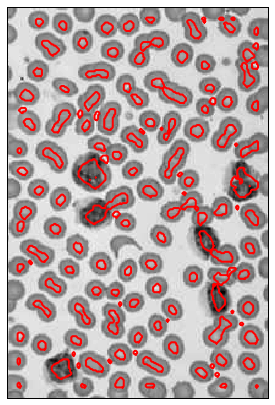

In [10]:
seg = output[:,:,0] > output[:,:,1]
contours = measure.find_contours(seg, 0.01)

fig, ax = plt.subplots()
ax.imshow(v_img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], '-r', linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.rcParams['figure.figsize'] = 7,7